In [1]:
# 📦 Standard imports
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Scanpy figure settings for consistency
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=100, frameon=True, figsize=(8, 8))


In [2]:
# 🚀 Load the processed pancancer single-cell dataset
adata = sc.read("../../data/processed/pancancer_dimred.h5ad")

# 🪐 Explore the structure for orientation
print("🧬 AnnData shape (cells x genes):", adata.shape)
print("\n📋 .obs preview:")
print(adata.obs.head())

print("\n🔎 .obs columns:")
print(adata.obs.columns.tolist())

print("\n🧬 .var (genes):", adata.var.shape)
print("📋 .var columns:", adata.var.columns.tolist())

print("\n📚 Layers available:", list(adata.layers.keys()))
print("\n🧠 Dimensionality reductions available:", list(adata.obsm.keys()))
print("\n🔗 .obs index (first 5):", adata.obs.index[:5].tolist())


🧬 AnnData shape (cells x genes): (39715, 30314)

📋 .obs preview:
                         size_factors  total_counts cell_line cell_line_norm  \
C32_SKIN                     0.598491   3937.553223       C32            C32   
NCIH446_LUNG                 0.404451   3395.153320   NCIH446        NCIH446   
MFE319_ENDOMETRIUM           1.081174   4233.473633    MFE319         MFE319   
SKNAS_AUTONOMIC_GANGLIA      0.694279   3880.139648     SKNAS          SKNAS   
NCIH2452_PLEURA              0.926227   3827.817871  NCIH2452       NCIH2452   

                              SIDM  
C32_SKIN                 SIDM00890  
NCIH446_LUNG             SIDM00965  
MFE319_ENDOMETRIUM       SIDM00333  
SKNAS_AUTONOMIC_GANGLIA  SIDM01101  
NCIH2452_PLEURA          SIDM00722  

🔎 .obs columns:
['size_factors', 'total_counts', 'cell_line', 'cell_line_norm', 'SIDM']

🧬 .var (genes): (30314, 6)
📋 .var columns: ['highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_nor

In [3]:
# 🩺 Load tissue dummy matrix for tissue annotation
tissue_df = pd.read_csv("../02_feature_engineering/feature_engineering/processed_tissue_dummies.csv")

# Extract tissue labels from dummy columns
tissue_cols = [col for col in tissue_df.columns if col.startswith("Tissue_")]
tissue_df["Tissue"] = tissue_df[tissue_cols].idxmax(axis=1).str.replace("Tissue_", "")

# Map using SIDM identifiers
tissue_map = tissue_df.set_index("SANGER_MODEL_ID")["Tissue"]

# Add to AnnData
adata.obs["Tissue"] = adata.obs["SIDM"].map(tissue_map)

print("✅ Tissue annotation added:")
print(adata.obs[["SIDM", "Tissue"]].head())


✅ Tissue annotation added:
                              SIDM                     Tissue
C32_SKIN                 SIDM00890                       Skin
NCIH446_LUNG             SIDM00965                       Lung
MFE319_ENDOMETRIUM       SIDM00333                Endometrium
SKNAS_AUTONOMIC_GANGLIA  SIDM01101  Peripheral Nervous System
NCIH2452_PLEURA          SIDM00722                       Lung


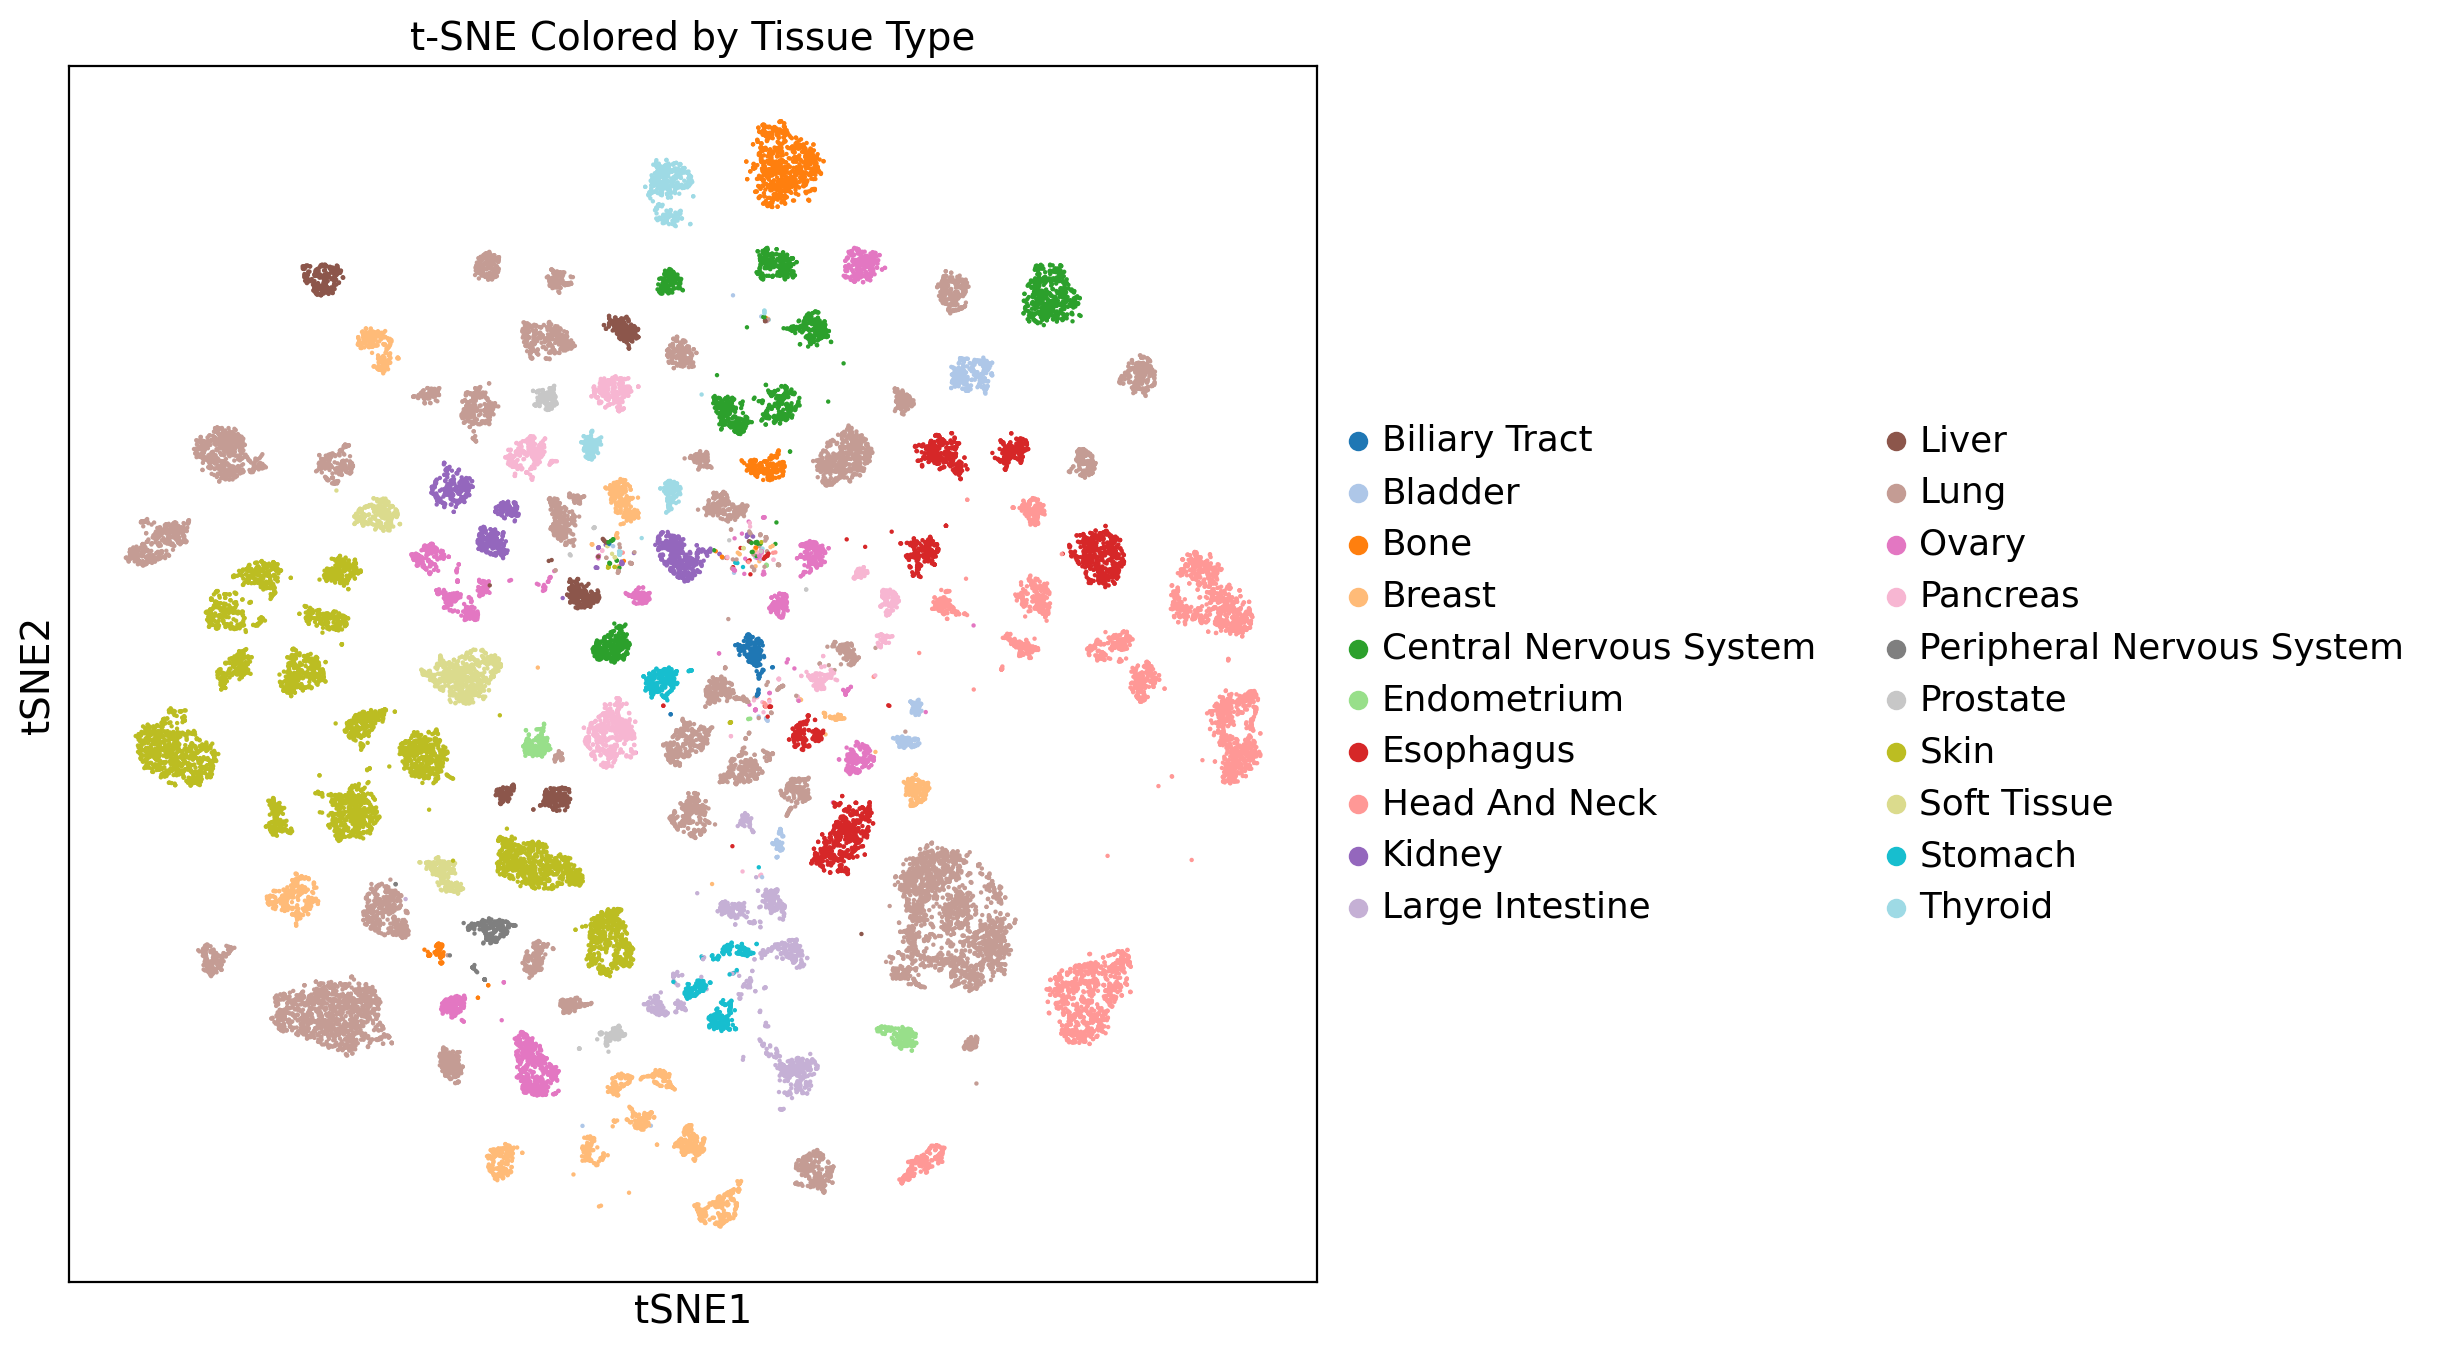

In [4]:
# 🎨 Visualize t-SNE colored by tissue
sc.pl.tsne(
    adata,
    color="Tissue",
    title="t-SNE Colored by Tissue Type",
    legend_loc="right margin",
    frameon=True,
    size=10,
    palette="tab20"
)


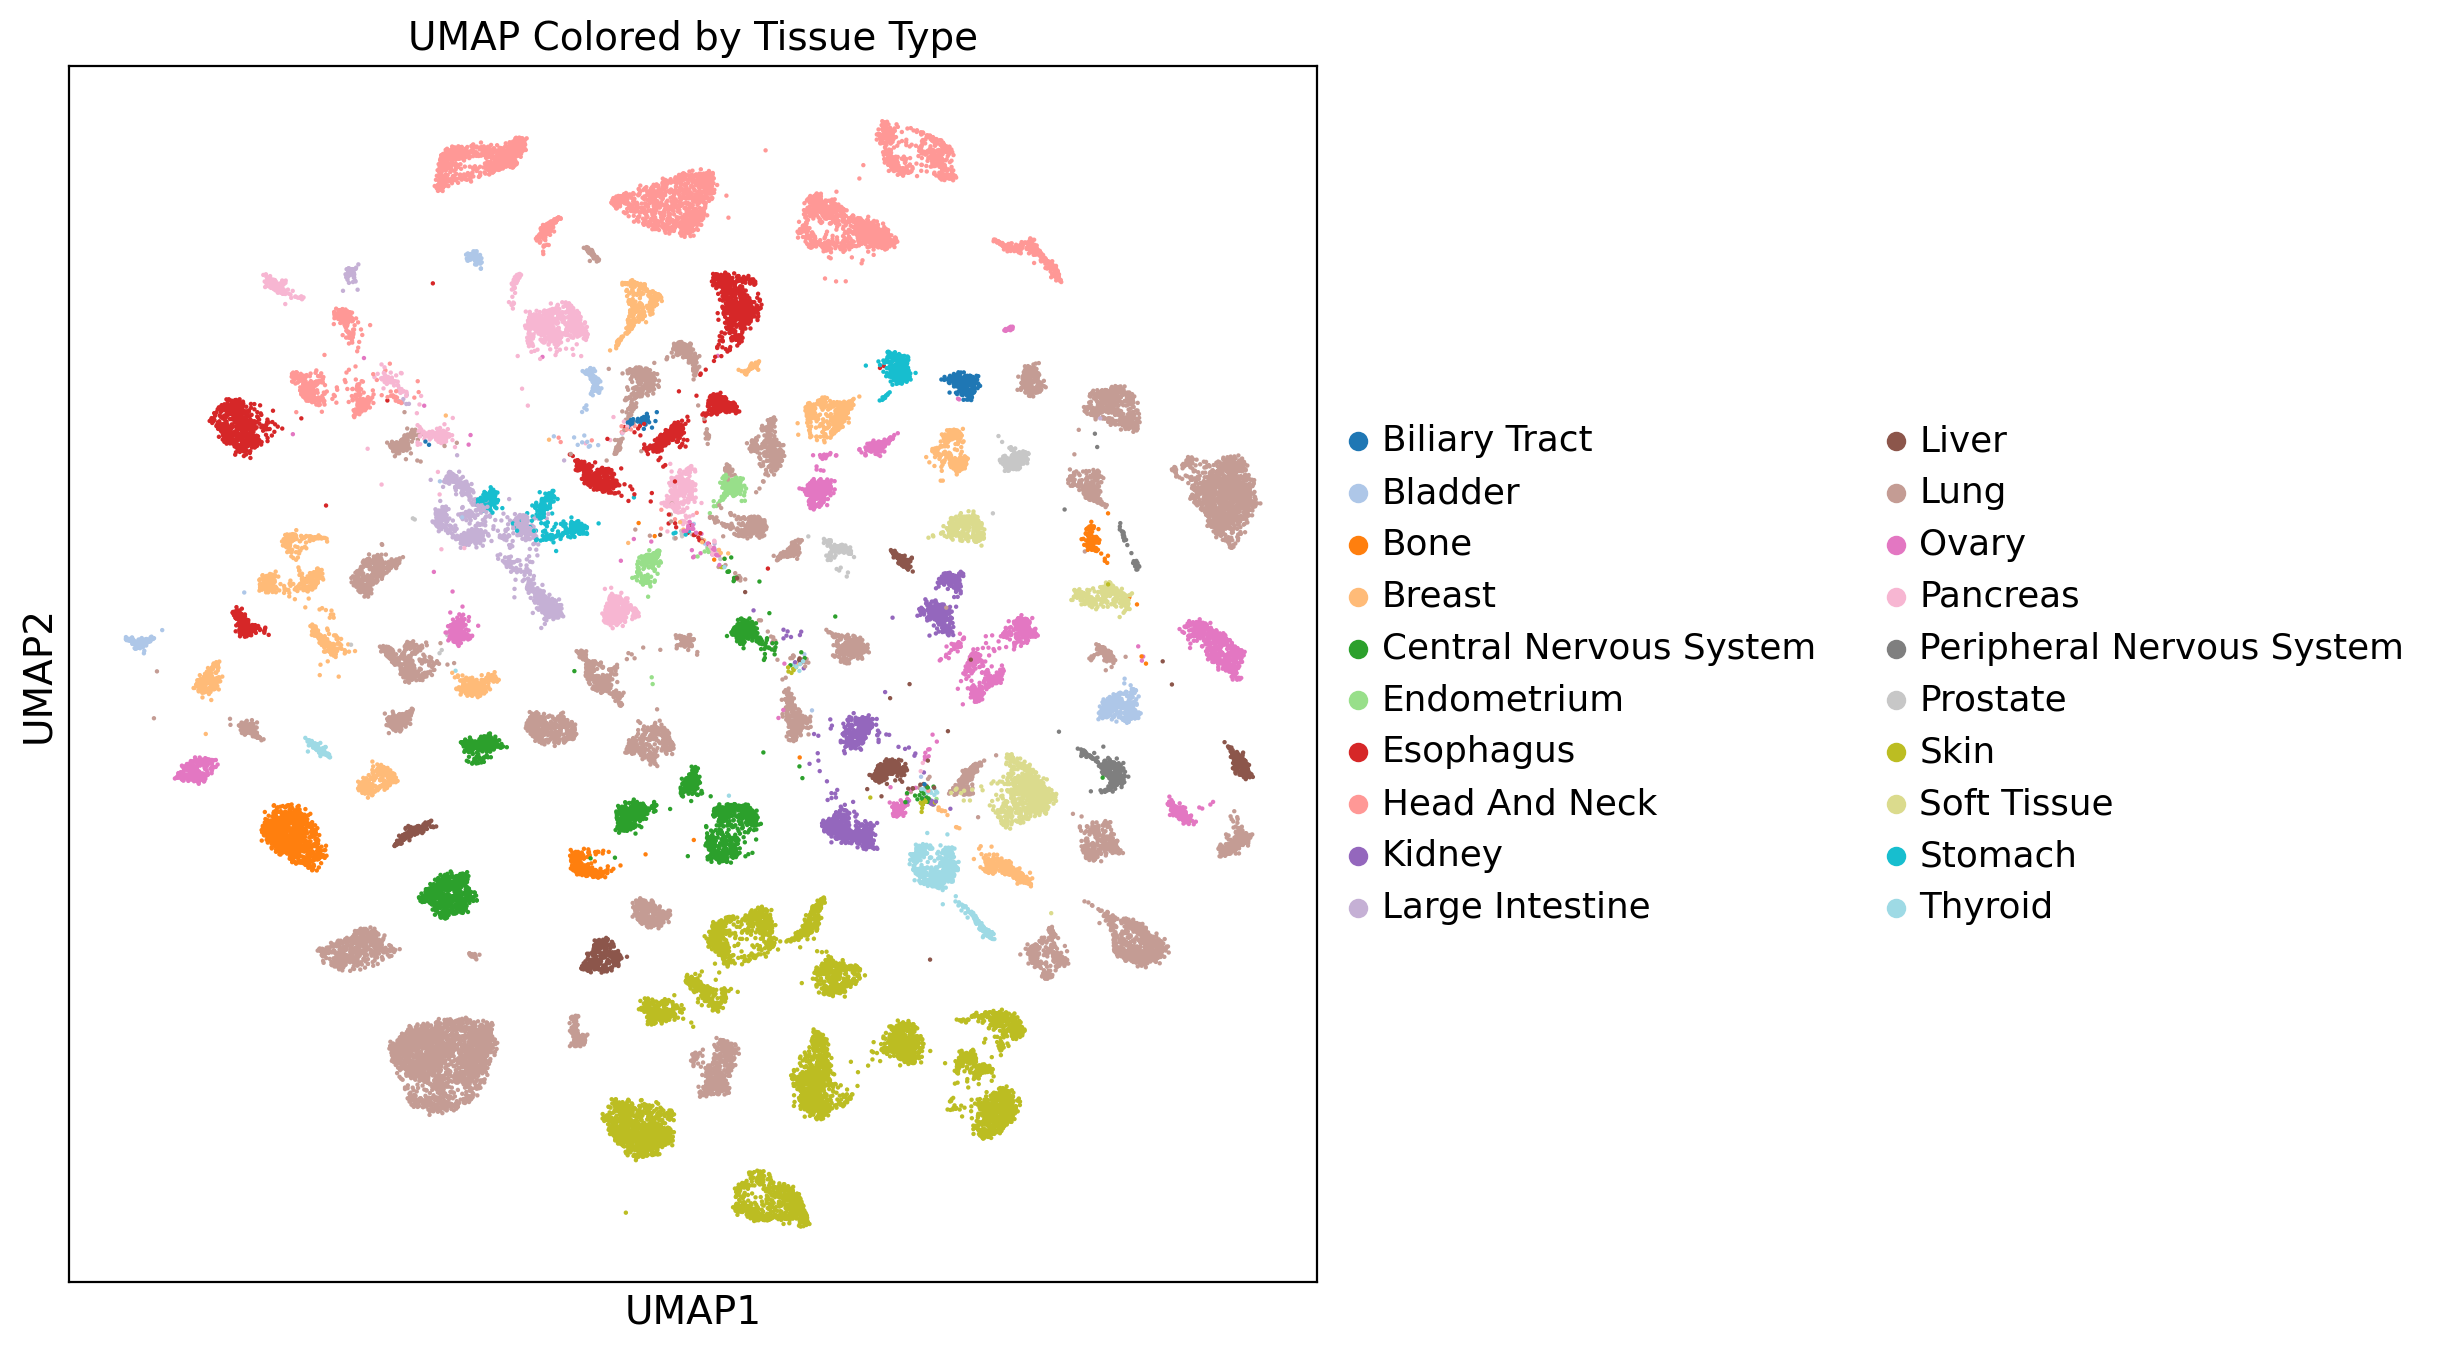

In [5]:
# 🧬 Compute UMAP if not available
if "X_umap" not in adata.obsm_keys():
    print("⚠️ UMAP not found, computing...")
    sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_pca")
    sc.tl.umap(adata)

# 🎨 Visualize UMAP colored by tissue
sc.pl.umap(
    adata,
    color="Tissue",
    title="UMAP Colored by Tissue Type",
    legend_loc="right margin",
    frameon=True,
    size=10,
    palette="tab20"
)


In [1]:
# Imports (safe if re-run)
import numpy as np
import scanpy as sc

# ---------------------------
# 1) Ensure UMAP is computed from ALL genes
# ---------------------------
# We will (a) place log1p-normalized values into .X temporarily (if a 'log1p_norm' layer exists),
# (b) run PCA/Neighbors/UMAP with use_highly_variable=False, and then (c) optionally restore .X.
adata = sc.read("../../data/processed/pancancer_dimred.h5ad")

# Use the log1p-normalized layer for geometry if present
_use_log1p_layer = "log1p_norm" in getattr(adata, "layers", {})
X_backup = None

if "X_umap" not in adata.obsm_keys():
    if _use_log1p_layer:
        # Temporarily use log1p_norm as .X to compute geometry from ALL genes
        X_backup = adata.X
        adata.X = adata.layers["log1p_norm"]

    # PCA/Neighbors/UMAP on ALL genes (no HVG selection)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=False, svd_solver="arpack")
    sc.pp.neighbors(adata, n_pcs=50, random_state=0)
    sc.tl.umap(adata, min_dist=0.3, spread=1.0, random_state=0)

    if X_backup is not None:
        adata.X = X_backup

print("UMAP available in adata.obsm['X_umap'] and was computed on ALL cells.")



UMAP available in adata.obsm['X_umap'] and was computed on ALL cells.


In [2]:
import numpy as np

genes_of_interest = ["VIM", "CDH1"]
missing = [g for g in genes_of_interest if g not in adata.var_names]
print("Missing genes:", missing if missing else "None")

expr_layer = "log1p_norm" if "log1p_norm" in adata.layers else None
if expr_layer is None:
    print("Warning: 'log1p_norm' not found. Using .X for coloring.")

def _get_gene_expr(a, gene, layer_name=None):
    if gene not in a.var_names:
        return np.zeros(a.n_obs, dtype=float)
    Xg = a[:, gene].layers[layer_name] if layer_name is not None else a[:, gene].X
    return np.asarray(Xg).ravel()  # dense 1D

adata.obs["VIM_expr"] = _get_gene_expr(adata, "VIM", expr_layer)
adata.obs["CDH1_expr"] = _get_gene_expr(adata, "CDH1", expr_layer)

for g in ["VIM_expr", "CDH1_expr"]:
    arr = adata.obs[g].to_numpy()
    if np.any(arr):
        p1, p99 = np.percentile(arr, [1, 99])
        print(f"{g}: min={arr.min():.3f}, p1={p1:.3f}, median={np.median(arr):.3f}, p99={p99:.3f}, max={arr.max():.3f}")
    else:
        print(f"{g}: all zeros (gene likely missing).")


Missing genes: None
VIM_expr: min=0.000, p1=0.000, median=2.327, p99=5.111, max=6.154
CDH1_expr: min=0.000, p1=0.000, median=0.000, p99=1.600, max=2.730


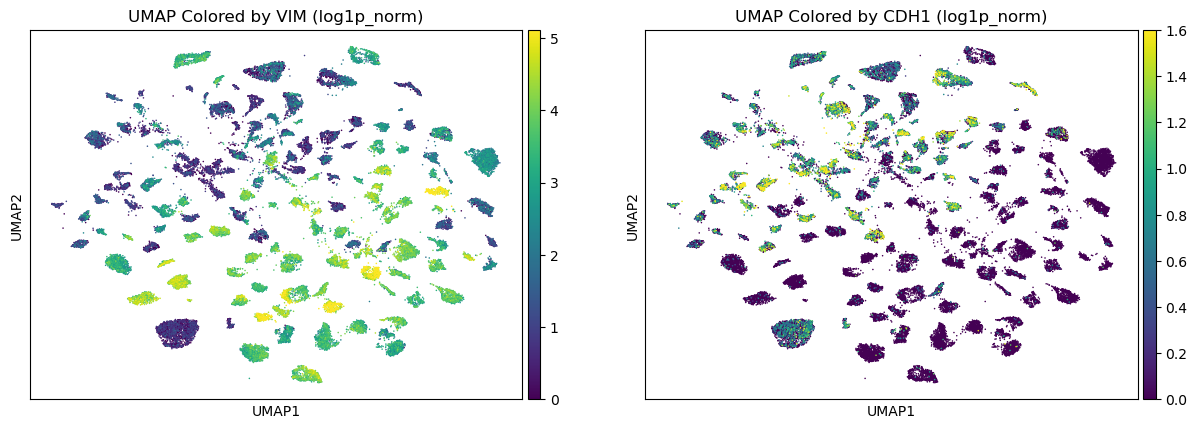

In [3]:
sc.pl.umap(
    adata,
    color=["VIM_expr", "CDH1_expr"],
    color_map="viridis",
    vmin=0.0,
    vmax="p99",             # robust cap for outliers
    size=5,
    ncols=2,
    frameon=True,
    title=["UMAP Colored by VIM (log1p_norm)", "UMAP Colored by CDH1 (log1p_norm)"],
    legend_loc=None
)


Quantify the EMT signal and the VIM–CDH1 anti-correlation

In [4]:
# Assumes `adata` already has the full UMAP and that you've added VIM_expr/CDH1_expr.
# If not, this cell will create them from the 'log1p_norm' layer if available.

import numpy as np
import scanpy as sc

# Ensure expression columns exist
expr_layer = "log1p_norm" if "log1p_norm" in adata.layers else None

def _get_gene_expr(a, gene, layer_name=None):
    if gene not in a.var_names:
        return np.zeros(a.n_obs, dtype=float)
    Xg = a[:, gene].layers[layer_name] if layer_name is not None else a[:, gene].X
    return np.asarray(Xg).ravel()

for g in ["VIM_expr", "CDH1_expr"]:
    if g not in adata.obs:
        gene = g.split("_")[0]
        adata.obs[g] = _get_gene_expr(adata, gene, expr_layer)

# Global anti-correlation (Spearman is robust to nonlinearity)
from scipy.stats import spearmanr, pearsonr
rho, p_rho = spearmanr(adata.obs["VIM_expr"], adata.obs["CDH1_expr"])
r, p_r = pearsonr(adata.obs["VIM_expr"], adata.obs["CDH1_expr"])
print(f"Spearman rho = {rho:.3f} (p={p_rho:.1e}); Pearson r = {r:.3f} (p={p_r:.1e})")


Spearman rho = -0.415 (p=0.0e+00); Pearson r = -0.396 (p=0.0e+00)


Build a per-cell EMT score and visualize it on the same UMAP

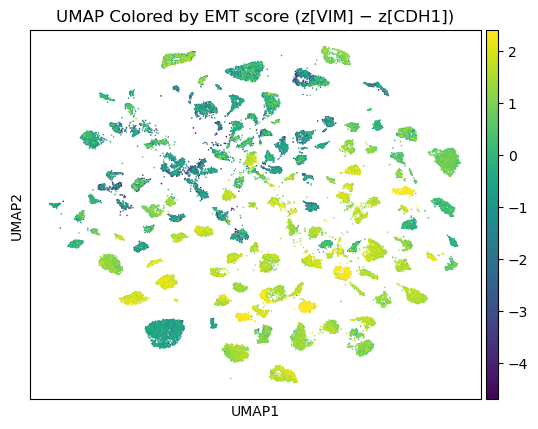

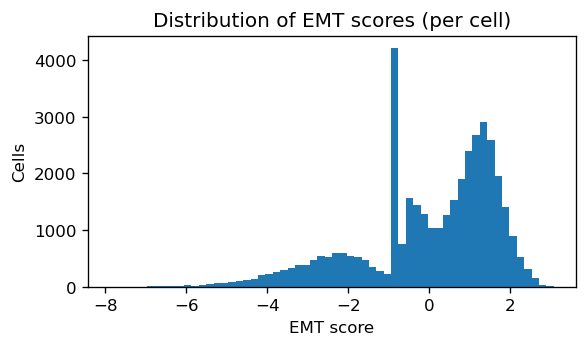

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# z-score within the dataset and take VIM - CDH1 so higher = more mesenchymal
def _z(x):
    x = np.asarray(x, float)
    mu, sd = np.nanmean(x), np.nanstd(x) if np.nanstd(x) > 0 else 1.0
    return (x - mu) / sd

adata.obs["EMT_score"] = _z(adata.obs["VIM_expr"]) - _z(adata.obs["CDH1_expr"])

# Plot EMT on the same embedding
sc.pl.umap(
    adata,
    color="EMT_score",
    color_map="viridis",
    vmin=np.percentile(adata.obs["EMT_score"], 1),
    vmax=np.percentile(adata.obs["EMT_score"], 99),
    size=5,
    title="UMAP Colored by EMT score (z[VIM] − z[CDH1])",
    legend_loc=None
)

# Distribution (all cells)
fig, ax = plt.subplots(figsize=(5,3), dpi=120)
ax.hist(adata.obs["EMT_score"].dropna(), bins=60)
ax.set_title("Distribution of EMT scores (per cell)")
ax.set_xlabel("EMT score")
ax.set_ylabel("Cells")
plt.tight_layout()
plt.show()


Summarize EMT by cell line (or tissue) to support the “heterogeneity” claim

/tmp/ipykernel_516743/2283415780.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_cols)["EMT_score"]


,cell_line,median,iqr,n
3,A204,2.338000,0.475323,253
116,SKMEL30,2.274611,0.431440,355
105,RVH421,2.222389,0.323542,243
1,8305C,2.135341,0.411618,459
21,COLO792,1.959610,0.503396,282
0,42MGBA,1.851275,0.347913,560
120,SNU423,1.797912,0.447875,222
38,HS939T,1.752420,0.382735,236
135,TOV112D,1.747465,0.435255,165
91,NCIH2452,1.682440,0.476055,551


,cell_line,median,iqr,n
58,LNCAPCLONEFGC,-2.605568,2.716493,131
109,SCC90,-2.611060,2.717086,258
124,SW1116,-2.697661,0.958499,22
122,SU8686,-2.725521,1.570688,82
60,LS1034,-2.800590,2.822438,153
34,HCC1428,-2.835765,2.062256,128
39,HT55,-3.146428,2.078462,211
104,RT4,-3.337668,1.968362,107
67,MKN45,-3.431681,1.892687,119
62,MDAMB361,-3.709513,2.030309,135


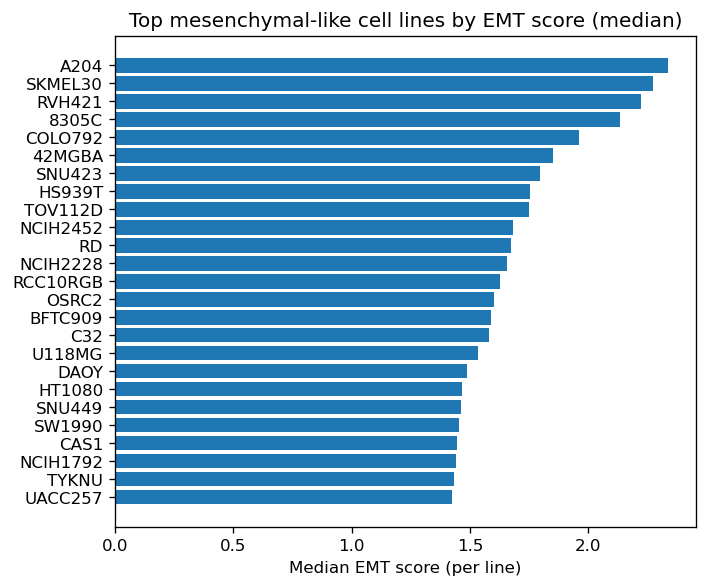

In [6]:
import pandas as pd
assert "cell_line" in adata.obs.columns, "adata.obs['cell_line'] is required"
group_cols = ["cell_line"]  # change to ["tissue"] for tissue-level summary

summ = (adata.obs
        .groupby(group_cols)["EMT_score"]
        .agg(median="median", iqr=lambda x: np.subtract(*np.percentile(x, [75,25])),
             n="count")
        .reset_index()
        .sort_values("median", ascending=False))

# Top/bottom lines by EMT
display(summ.head(10))
display(summ.tail(10))

# If you want a quick bar plot of the top 25 most mesenchymal-like lines:
top_k = 25
fig, ax = plt.subplots(figsize=(6,5), dpi=120)
tmp = summ.head(top_k).iloc[::-1]
ax.barh(tmp["cell_line"], tmp["median"])
ax.set_xlabel("Median EMT score (per line)")
ax.set_title("Top mesenchymal-like cell lines by EMT score (median)")
plt.tight_layout(); plt.show()
